In [29]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [30]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's
categorical features. Other tables are using one-hot encode with mean,
sum and a few different functions to aggregate. The main ideia was to add
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import numpy as np
import pandas as pd
import cudf
import cuml
import gc
import cupy as cp
from cuml.pipeline import Pipeline
from cuml.preprocessing import StandardScaler
from cuml.preprocessing import SimpleImputer

# from cuml.preprocessing import RobustScaler
import matplotlib.pyplot as plt

# import seaborn as sns
import joblib
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb

from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import pickle
import warnings

from pprint import pprint
from mlflow import MlflowClient

warnings.simplefilter(action="ignore", category=FutureWarning)
## np.warnings.filterwarnings("ignore", r"All-NaN (slice|axis) encountered")
# np.seterr(all="ignore", invalid="ignore")

In [ ]:
from src.p7_feature_selection import DataSelector
from src.p7_feature_selection import cluster_features
from src.p7_simple_kernel import kfold_lightgbm_simple
from src.p7_simple_kernel import display_importances
from src.p7_full_kernel import display_full_importances
from src.p7_constantes import (
    NUM_THREADS,
    DATA_CLEAN_DIR,
    DATA_INTERIM,
    MODEL_DIR,
    VAL_SEED,
)
from src.p7_util import timer, reduce_memory_cudf
from src.p7_preprocess import Imputer, VarianceSelector, CuRobustScaler, CuMinMaxScaler
from src.p7_preprocess import ImputerByDtype
from src.p7_preprocess import WithColNames
from src.p7_explore import plot_default_ratio, corr_sorted_map, corr_cluster_map
from src.p7_feature_selection import get_features_correlated_above, cluster_features
from src.p7_feature_selection import VIFSelectorCV
from src.p7_tracking import ExpCorr, ExpPermutation
from src.p7_importance import importance_from_model, plot_line_importance


%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
print("cuDF version:", cudf.__version__)
print("cuML version:", cuml.__version__)

cuDF version: 24.04.01
cuML version: 24.04.00


# Lecture des données de Train

In [175]:
train = cudf.read_csv(os.path.join(DATA_INTERIM, "01_v1_miss_200_train.csv"))
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 555 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float64(357), int64(40)
memory usage: 743.8 MB


In [176]:
train = reduce_memory_cudf(train)

Memory usage of dataframe is 743.80 MB
Memory usage after optimization is: 416.51 MB
Decreased by 44.0%


# Evaluer le temps de traitement d'une itération pour le VIF

## En validation croisée

In [177]:
X = train.drop(columns=["SK_ID_CURR", "TARGET"])
y = train["TARGET"].astype(np.float64)

print("Info X :")
print(X.info())
print("\nInfo y :")
print("Classe", y.__class__.__name__)
print("Type", y.dtype)
print("Shape", y.shape)

Info X :
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 553 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float32(345), float64(12), int32(25), int64(13)
memory usage: 414.8 MB
None

Info y :
Classe Series
Type float64
Shape (230634,)


In [ ]:
# On libère la mémoire CPU et GPU
del train
gc.collect()
cp._default_memory_pool.free_all_blocks()

In [179]:
pipe = Pipeline(
    [
        ("imputer", WithColNames(SimpleImputer(copy=False))),
        # ("std", VarianceSelector(copy=False)),
        ("scaler", WithColNames(StandardScaler(copy=False))),
    ]
)

In [ ]:
# On limite le traitement à une itération
# et on demande une grande précision pour être sûr que le premier pire VIF soit calculé.
# Cela nous donnera une idée de l'ordre de grandeur du premier VIF
vif_selector0 = VIFSelectorCV(
    pipe_prepare=pipe,
    vif_threshold=10.0,
    n_splits=3,
)
vif_selector0.fit(X, y, max_iter=1, epsilon=1e-10)

Elimination récursive de features avec un VIF > 10
	Device : GPU
	shape X  : (230634, 553)
	Nombre de splits : 3

Itérations (1 itérations maximum)...
[Itération 1] (Elapsed time : 0:20:51) Max VIF: NAME_FAMILY_STATUS_NA = 396261549.17
Arrêt du processus car le maximum d'itérations (1 a été atteint)
Durée du Fit (hh:mm:ss) : 0:20:51
1 features ont un VIF trop élevé :
['NAME_FAMILY_STATUS_NA']
552 features restantes


VIFSelectorCV(pipe_prepare=Pipeline(steps=[('imputer',
                                            WithColNames(estimator=SimpleImputer())),
                                           ('scaler',
                                            WithColNames(estimator=StandardScaler()))]))

In [ ]:
"""
Environ 21 minutes par itération.
Il est impossible d'évaluer le nombre d'itérations nécessaires,
cependant, nous sommes très éloigné de la valeur VIF maximale : 396_261_549.
La procédure en validation croisée nous paraît inenvisageable.
"""

## Sans validation croisée

In [182]:
# On supprime tout de même la feature trouvée en validation croisée
X = X.drop(columns=vif_selector0.removed_features_)
X.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 552 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(157), float32(345), float64(12), int32(25), int64(13)
memory usage: 414.5 MB


## Imputation et mise à l'échelle

In [184]:
from src.p7_preprocess import train_test_split_nan

In [185]:
X_train, X_test, y_train, y_test = train_test_split_nan(X, y, test_size=0.25)
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

In [ ]:
# On concatène X_train et X_test l'un en dessous de l'autre
X = cudf.concat([X_train, X_test], axis=0)
# y n'est pas utilisé puisque nous n'avons pas de folds
# y = cudf.concat([y_train, y_test], axis=0)
print("Nombre de NA", X.isna().sum().sum())
X.head()

Nombre de NA 0


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_AMT_BALANCE_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_PAYMENT_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR
0,0.718223,-0.716319,-0.662478,0.800995,-0.490855,0.746675,0.555217,0.978332,0.562631,1.234783,...,5.008782e-16,2.874211e-16,-3.400167e-16,1.898392e-16,0.0,-5.264763e-16,2.828100e-16,-4.651147e-16,1.139328e-16,1.055631e-16
1,-1.392110,1.396027,-0.662478,-0.577422,-0.411930,-0.582325,-1.172121,-0.811189,-0.012403,0.818456,...,5.008782e-16,2.874211e-16,-3.400167e-16,1.898392e-16,0.0,-5.264763e-16,2.828100e-16,-4.651147e-16,1.139328e-16,1.055631e-16
2,0.718223,-0.716319,-0.662478,0.800995,-0.490855,-0.801067,-0.899204,-0.811189,0.755466,1.390734,...,5.008782e-16,2.874211e-16,-3.400167e-16,1.898392e-16,0.0,-5.264763e-16,2.828100e-16,-4.651147e-16,1.139328e-16,1.055631e-16
3,0.718223,-0.716319,-0.662478,2.179413,-0.096230,0.387335,0.645049,0.369652,0.755466,0.931584,...,-1.233853e+00,5.501052e+00,1.003588e+00,1.898392e-16,0.0,-5.264763e-16,2.828100e-16,-4.651147e-16,-7.866244e-01,-4.412351e-01
4,0.718223,-0.716319,-0.662478,-0.577422,-0.569780,0.087803,-0.583080,-0.226855,-0.012403,-1.172721,...,5.008782e-16,2.874211e-16,-3.400167e-16,1.898392e-16,0.0,-5.264763e-16,2.828100e-16,-4.651147e-16,1.139328e-16,1.055631e-16


## VIF sans validation croisée premières itérations

In [190]:
from src.p7_feature_selection import VIFSelector

# On lance le processus sur 3 itérations (ce qui devrait être à peu près équivallent à une itération sur 3 folds),
# et voyons où en est le VIF
selector = VIFSelector(vif_threshold=50)
selector.fit(X, epsilon=1e-10, max_iter=3)

Elimination récursive de features avec un VIF > 50
	Device : GPU
	shape X  : (230634, 552)
	Sans validation croisée

Itérations (3 itérations maximum)...
[Itération 1] (Elapsed time : 0:06:58) Max VIF: BURO_CREDIT_CURRENCY_currency4_MEAN = 668957618.55
[Itération 2] (Elapsed time : 0:13:56) Max VIF: POS_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN = 149795577.79
[Itération 3] (Elapsed time : 0:20:49) Max VIF: PREV_NAME_GOODS_CATEGORY_Animals_MEAN = 242559065.54
Arrêt du processus car le maximum d'itérations (3 a été atteint)
Durée du Fit (hh:mm:ss) : 0:20:49
3 features ont un VIF trop élevé :
['BURO_CREDIT_CURRENCY_currency4_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN', 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN']
549 features restantes


VIFSelector(vif_threshold=50)

In [ ]:
# On supprime ces features
X = X.drop(columns=selector.removed_features_)
X.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 230634 entries, 0 to 57657
Columns: 549 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: float64(549)
memory usage: 967.8 MB


In [ ]:
"""
On voit que même sans validation croisée, le traitement sera très long.
Avant de le poursuivre, on se pose la question de l'impact du déséquilibre du dataset sur le VIF
"""

'\nOn voit que même sans validation croisée, le traitement sera très long.\n'

# VIF et dataset déséquilibré

In [ ]:
"""
le dataset est déséquilibré, or la procédure repose sur des régressions linéaires (donc des corrélations).
Les R2 obtenus (donc les VIFs) auraient été différents en ré-équilibrant le dataset auparavant.

Pour tenter d'illustrer cela, nous allos créer un petit dataset tout simple.
"""

In [ ]:
"""
Nous créons un dataset avec un ratio de défaut de 8%.
Il comprend
- une feature "to_keep" égale à la target. Elle est donc 100% explicative, nous voulons la garder
- une feature "to_drop" très corrélée à la feature to_drop. Celle_ci est égale à to_keep sur la classe majoritaire
mais comporte de légères différences dans la classe minoritaire. Elle n'est donc pas prédictive à 100% de la target.
- deux features complètement aléatoires (non corrélées à rien)

La procédure VIF devrait nous éliminer ou "to_keep" ou "to_drop" car celles-ci sont corrélées (complètement égales sur la classe majoritaire).
Cependant, nous préfèrerions garder to_keep, puisque c'est la meilleure feature et éliminer les deux features aléatoires qui sont inutiles.
"""

In [208]:
import cudf
import cupy as cp

cp.random.seed(1)

# Nombre de lignes
n_rows = 1000

# Pourcentage de 1 dans la target
target_ones_ratio = 0.08
n_ones = int(n_rows * target_ones_ratio)
n_zeros = n_rows - n_ones

# Création de la colonne target avec 8% de 1, 92% de 0
# target = cp.array([1] * n_ones + [0] * n_zeros)
# cp.random.shuffle(target)
target = cp.array([0] * n_zeros + [1] * n_ones)

# to_keep est identique à target
to_keep = target.copy()

# to_drop : tout à 0 sauf UNE ligne aléatoire où target == 0 → 1
"""to_drop = cp.zeros(n_rows, dtype=cp.int32)
zero_indices = cp.where(target == 1)[0]
# random_zero_idx = int(cp.random.choice(zero_indices, 1))
random_zero_idx = int(cp.random.choice(zero_indices, 1)[0])
to_drop[random_zero_idx] = 1"""
# to_drop : tout à 0, sauf aux 3 premières lignes où target == 1 → 1
to_drop = cp.zeros(n_rows, dtype=cp.int32)
one_indices = cp.where(target == 1)[0]
selected_indices = one_indices[:73]  # Prend les 3 premiers
to_drop[selected_indices] = 1

# random1 : valeurs float aléatoires entre 0 et 1
random1 = cp.random.rand(n_rows)

# random2 : valeurs aléatoires entières entre 0 et 100
random2 = cp.random.randint(0, 100, size=n_rows)

# Création du DataFrame cuDF
df = cudf.DataFrame(
    {
        "random1": random1,
        "random2": random2,
        "target": target,
        "to_keep": to_keep,
        "to_drop": to_drop,
    }
)

print(df.head())

    random1  random2  target  to_keep  to_drop
0  0.724492        2       0        0        0
1  0.438243       90       0        0        0
2  0.505169       48       0        0        0
3  0.933551       77       0        0        0
4  0.791575       94       0        0        0


In [211]:
df[df["target"] == 1].tail()

,random1,random2,target,to_keep,to_drop
995,0.011827,47.0,1.0,1.0,0.0
996,0.165524,67.0,1.0,1.0,0.0
997,0.658897,79.0,1.0,1.0,0.0
998,0.947329,74.0,1.0,1.0,0.0
999,0.838986,32.0,1.0,1.0,0.0


In [210]:
from src.p7_feature_selection import VIFSelector

selector_tmp = VIFSelector(vif_threshold=10.0)
df = df.astype(np.float64)
X_tmp = df.drop(columns=["target"])
y_tmp = df["target"]
selector_tmp.fit(X=X_tmp)

Elimination récursive de features avec un VIF > 10
	Device : GPU
	shape X  : (1000, 4)
	Sans validation croisée

Itérations (30 itérations maximum)...
[Itération 1] (Elapsed time : 0:00:00) Max VIF: to_keep = 10.60
[Itération 2] (Elapsed time : 0:00:00) Max VIF: to_drop = 1.00
Durée du Fit (hh:mm:ss) : 0:00:00
1 features ont un VIF trop élevé :
['to_keep']
3 features restantes


VIFSelector()

In [ ]:
"""
Ici nous éliminons la feature que nous voudrions conserver.
to_keep est 100% identique à  la target, tandis que "to_drop" a 7 lignes différentes (sur 1000 lignes au total et sur 80 de la classe minoritaire)
Certes, il n'est pas grave d'échanger "to_keep" par "to_drop", tant que nous ne rééquilibrons pas le dataset.
En effet, avec le déséquilibre actuel, les deux features sont très corrélées entre elles et très corrélées avec la target.

Mais si nous rééquilibrons le dataset, to_keep sera toujours 100% explicatives de la target, tandis que to_drop le sera moins.
Sur un dataset tout simple comme cet exemple, on peut voir que l'impact du déséquilibre n'est pas important sur le VIF (sans ré-équilibrage).

Mais qu'en est-il sur un dataset volumineux comme le nôtre, qui comporte des multi_colinéarités complexes ?
L'élimination des features grâce au VIF améliorera-t-elle obligatoirement la performance des modèles ?
C'est plus difficile à évaluer.
"""

# Poursuite de l'élimination récursive des features au VIF très élevé

In [ ]:
"""
En raison du temps de calcul, mais aussi en raison de l'incertitude sur la qualité de la procédure pour des datasets déséquilibrés,
On n'effectue la procédure que jusqu'à un seuil très élevé du VIF (et non pas 10 ou 5 comme habituellement)
"""

In [214]:
# Nous prévoyons une grande précision (1e-10 pour epsilon est une garantie que le R2 sera calculé et ne sera pas np.inf),
# car nous souhaitons savoir où nous en sommes à peu près au sujet du pire VIF trouvé.
# 30 itérations * 7 minutes devrait nous mener à environ 3h30 de temps de calcul au pire
# (Le seuil du VIF à 50_000 est fixé arbitrairement).
selector2 = VIFSelector(vif_threshold=50_000)
selector2.fit(X, epsilon=1e-10, max_iter=30)

Elimination récursive de features avec un VIF > 50000
	Device : GPU
	shape X  : (230634, 549)
	Sans validation croisée

Itérations (30 itérations maximum)...
[Itération 1] (Elapsed time : 0:10:16) Max VIF: PREV_NAME_CASH_LOAN_PURPOSE_Refusaltonamethegoal_MEAN = 195743645.75
[Itération 2] (Elapsed time : 0:17:24) Max VIF: PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN = 149817862.38
[Itération 3] (Elapsed time : 0:24:28) Max VIF: PREV_CHANNEL_TYPE_Cardealer_MEAN = 24997284.36
[Itération 4] (Elapsed time : 0:31:33) Max VIF: PREV_NAME_PORTFOLIO_Cars_MEAN = 30061195.74
[Itération 5] (Elapsed time : 0:37:36) Max VIF: PREV_NAME_CLIENT_TYPE_XNA_MEAN = 69198658.65
[Itération 6] (Elapsed time : 0:43:37) Max VIF: BURO_CREDIT_ACTIVE_Baddebt_MEAN = 36461540.08
[Itération 7] (Elapsed time : 0:49:30) Max VIF: PREV_PRODUCT_COMBINATION_NA_MEAN = 43128724.81
[Itération 8] (Elapsed time : 0:55:28) Max VIF: PREV_NAME_CONTRACT_TYPE_XNA_MEAN = 69046001.87
[Itération 9] (Elapsed time : 1:01

VIFSelector(vif_threshold=50000)

### Sauvegarde

In [217]:
to_drop_vif = selector2.removed_features_

In [218]:
filepath_X_vif = os.path.join(DATA_INTERIM, "01_v2_vif_X_fold.csv")
X.drop(columns=to_drop_vif).to_csv(filepath_X_vif, index=False)
print(
    f"X_fold après suppression des colonnes (VIF > 50000) enregistré dans {filepath_X_vif}"
)
X.drop(columns=to_drop_vif).info()

X_fold après suppression des colonnes (VIF > 50000) enregistré dans data/interim/01_v2_vif_X_fold.csv
<class 'cudf.core.dataframe.DataFrame'>
Index: 230634 entries, 0 to 57657
Columns: 521 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: float64(521)
memory usage: 918.5 MB


In [219]:
train = cudf.read_csv(os.path.join(DATA_INTERIM, "01_v1_miss_200_train.csv"))
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 555 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float64(357), int64(40)
memory usage: 743.8 MB


In [220]:
train = train[["SK_ID_CURR", "TARGET"] + selector2.selected_features_]
filepath_train = os.path.join(DATA_CLEAN_DIR, "01_v2_vif_train.csv")
train.to_csv(filepath_train, index=False)
print(
    f"train après suppression des colonnes (VIF trop important) enregistré dans {filepath_train}"
)
train.info()

train après suppression des colonnes (VIF trop important) enregistré dans data/cleaned/01_v2_vif_train.csv
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 523 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(157), float64(327), int64(39)
memory usage: 688.2 MB


In [ ]:
"""
A ce stade, toutes les features ont un VIF de moins de 50_000, c'est encore très loin de l'objectif de 10 habituellement.
Cependant nous n'allons pas continuer plus loin. Nous allons plutôt utiliser d'autres méthodes de sélection de features.
"""

"\nA ce stade, toutes les features ont un VIF de moins de 50_000, c'est encore très loin de l'objectif de 10 habituellement.\nCependant nous n'allons pas continuer plus loi,.\n"

# Features importantes

## Modèle

In [54]:
model = lgb.LGBMClassifier(
    nthread=14,
    class_weight="balanced",
    objective="binary",
    random_state=VAL_SEED,
    # boost_from_average=False, # Sion souhaitait comparer api sklearn et api native,
    verbosity=-1,  # Pour ne pas voir les logs
)
params_lgbm_clf = model.get_params()
print("Pramètres du cmassifieur LightGBM :")
print(params_lgbm_clf)

Pramètres du cmassifieur LightGBM :
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': 14, 'verbosity': -1}


## Calcul des importances

In [55]:
predictors = [f for f in train.columns if f not in ["SK_ID_CURR", "TARGET"]]
X = train[predictors].to_pandas()
y = train["TARGET"].to_pandas()

In [56]:
importance_df = importance_from_model(model, X, y, n_splits=5)

## Selection des plus importantes (à conserver même si le VIF est élevé)

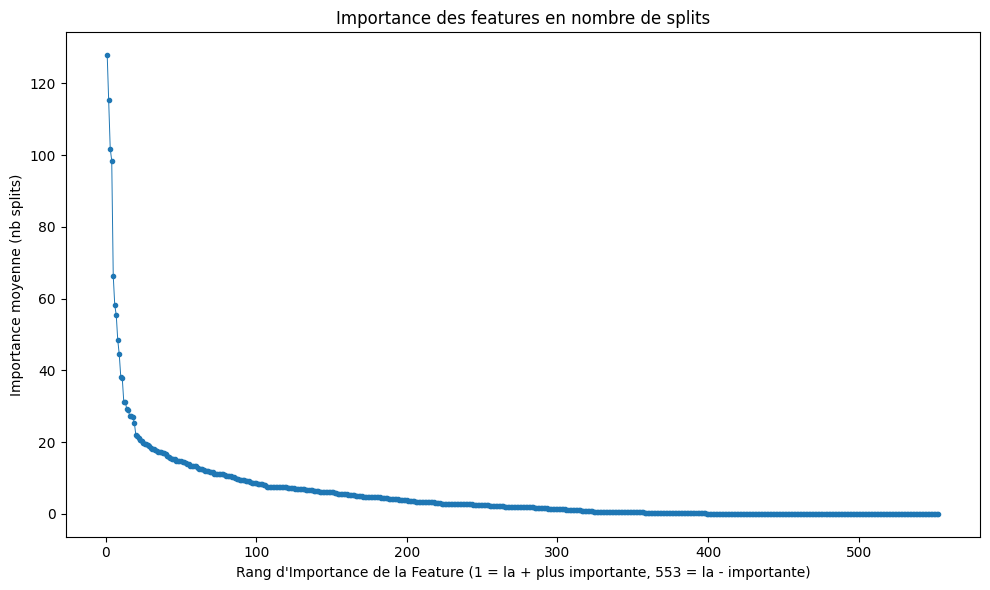

In [57]:
fig = plot_line_importance(importance_df)

In [58]:
threshold_rank = 150
most_important_features = list(
    importance_df[importance_df["rank_importance"] <= threshold_rank].index
)
print(f"Les {threshold_rank} features les plus importantes :")
print(most_important_features)

Les 150 features les plus importantes :
['EXT_SOURCE_1', 'EXT_SOURCE_2', 'CREDIT_TO_ANNUITY_RATIO', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'CREDIT_TO_GOODS_RATIO', 'AMT_ANNUITY', 'INSTAL_DPD_MEAN', 'APPROVED_CNT_PAYMENT_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'INSTAL_AMT_PAYMENT_SUM', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_DAYS_CREDIT_MAX', 'AMT_GOODS_PRICE', 'CODE_GENDER', 'ANNUITY_TO_INCOME_RATIO', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'INSTAL_AMT_PAYMENT_MIN', 'CC_CNT_DRAWINGS_CURRENT_VAR', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE', 'CLOSED_DAYS_CREDIT_MAX', 'APPROVED_AMT_DOWN_PAYMENT_MAX', 'INSTAL_DBD_SUM', 'POS_SK_DPD_DEF_MEAN', 'PREV_NAME_YIELD_GROUP_low_action_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAY

# VIF

## X, y

In [ ]:
"""from cuml.model_selection import StratifiedKFold as CuStratifiedKFold
from cuml.pipeline import Pipeline as CuPipeline
from cuml.preprocessing import StandardScaler as CuStandardScaler
from cuml.preprocessing import SimpleImputer as CuSimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, check_is_fitted
from cuml.linear_model import LinearRegression as CuLinearRegression
from cuml.metrics import r2_score
import time
from src.p7_preprocess import check_variances, cu_build_folds_list
from src.p7_preprocess import WithColNames
from src.p7_constantes import VAL_SEED
from src.p7_feature_selection import VIFSelectorCV
from src.p7_util import format_time
from src.p7_constantes import EPSILON"""

In [59]:
X = train.drop(columns=["SK_ID_CURR", "TARGET"])
y = train["TARGET"].astype(np.float64)

print("Info X :")
print(X.info())
print("\nInfo y :")
print("Classe", y.__class__.__name__)
print("Type", y.dtype)
print("Shape", y.shape)

Info X :
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 553 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float32(345), float64(12), int32(25), int64(13)
memory usage: 414.8 MB
None

Info y :
Classe Series
Type float64
Shape (230634,)


In [60]:
del train
gc.collect()
cp._default_memory_pool.free_all_blocks()

## Exécution VIF en validation croisée 3 folds

In [61]:
pipe = Pipeline(
    [
        ("imputer", WithColNames(SimpleImputer(copy=False))),
        # ("std", VarianceSelector(copy=False)),
        ("scaler", WithColNames(StandardScaler(copy=False))),
    ]
)

In [62]:
vif_selector_cv = VIFSelectorCV(
    pipe_prepare=pipe,
    vif_threshold=10.0,
    n_splits=3,
    important_features=most_important_features,
)
vif_selector_cv.fit(X, y)

Elimination récursive de features avec un VIF > 10
	Device : GPU
	shape X  : (230634, 553)
	Nombre de splits : 3

Itérations...
[Itération 1] (Elapsed time : 0:21:33) Max VIF: CNT_FAM_MEMBERS = inf
[Itération 2] (Elapsed time : 0:42:55) Max VIF: BURO_CREDIT_ACTIVE_Active_MEAN = inf
[Itération 3] (Elapsed time : 1:04:12) Max VIF: BURO_CREDIT_CURRENCY_currency1_MEAN = inf
[Itération 4] (Elapsed time : 1:25:22) Max VIF: PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN = inf
[Itération 5] (Elapsed time : 1:46:28) Max VIF: BURO_CREDIT_TYPE_Consumercredit_MEAN = inf
[Itération 6] (Elapsed time : 2:07:14) Max VIF: PREV_NAME_CONTRACT_TYPE_XNA_MEAN = inf
[Itération 7] (Elapsed time : 2:28:02) Max VIF: PREV_NAME_CASH_LOAN_PURPOSE_Buildingahouseoranannex_MEAN = inf
[Itération 8] (Elapsed time : 2:49:06) Max VIF: PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN = inf
[Itération 9] (Elapsed time : 3:07:01) Max VIF: PREV_CODE_REJECT_REASON_SCO_MEAN = inf
[Itération 10] (Elapsed time : 3:24

VIFSelectorCV(important_features=['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                  'CREDIT_TO_ANNUITY_RATIO', 'EXT_SOURCE_3',
                                  'DAYS_EMPLOYED', 'DAYS_BIRTH',
                                  'CREDIT_TO_GOODS_RATIO', 'AMT_ANNUITY',
                                  'INSTAL_DPD_MEAN',
                                  'APPROVED_CNT_PAYMENT_MEAN',
                                  'PREV_CNT_PAYMENT_MEAN', 'OWN_CAR_AGE',
                                  'DAYS_ID_PUBLISH', 'INSTAL_AMT_PAYMENT_SUM',
                                  'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
                                  'ACTIVE_DAYS_CRE...
                                  'INSTAL_PAYMENT_DIFF_MEAN',
                                  'POS_MONTHS_BALANCE_SIZE',
                                  'INSTAL_AMT_PAYMENT_MIN',
                                  'CC_CNT_DRAWINGS_CURRENT_VAR',
                                  'DAYS_LAST_PHONE_CHANGE',
                                  'REGION_POPULATION_RELATIVE',
                                  'CLOSED_DAYS_CREDIT_MAX',
                                  'APPROVED_AMT_DOWN_PAYMENT_MAX',
                                  'INSTAL_DBD_SUM', ...],
              pipe_prepare=Pipeline(steps=[('imputer',
                                            WithColNames(estimator=SimpleImputer())),
                                           ('scaler',
                                            WithColNames(estimator=StandardScaler()))]))

In [63]:
print(f"{len(vif_selector_cv.removed_features_)} features supprimées :")
print(vif_selector_cv.removed_features_)
print(f"\n{len(vif_selector_cv.selected_features_)} features conservées")
print("Variables retenues :", vif_selector_cv.selected_features_)
print("\nVIF moyens :", vif_selector_cv.get_vif_means())

21 features supprimées :
['CNT_FAM_MEMBERS', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'BURO_CREDIT_CURRENCY_currency1_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN', 'BURO_CREDIT_TYPE_Consumercredit_MEAN', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buildingahouseoranannex_MEAN', 'PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN', 'PREV_CODE_REJECT_REASON_SCO_MEAN', 'PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN', 'PREV_NAME_CLIENT_TYPE_Refreshed_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN', 'PREV_NAME_GOODS_CATEGORY_AdditionalService_MEAN', 'PREV_NAME_PORTFOLIO_Cars_MEAN', 'PREV_NAME_CONTRACT_STATUS_Unusedoffer_MEAN', 'PREV_CHANNEL_TYPE_Cardealer_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN', 'PREV_PRODUCT_COMBINATION_POSotherwithinterest_MEAN', 'PREV_PRODUCT_COMBINATION_NA_MEAN', 'PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN', 'PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN']

532 features conservées
Variables retenues : ['CODE_GENDER', 'FLAG_OW

## Sauvegarde 01_v2_vif_train

In [ ]:
# On relit train car on l'avait supprimé pour libérer la mémoire

In [64]:
train = cudf.read_csv(os.path.join(DATA_INTERIM, "01_v1_miss_200_train.csv"))
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 555 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float64(357), int64(40)
memory usage: 743.8 MB


In [ ]:
to_drop_vif = vif_selector_cv.removed_features_
filepath_train = os.path.join(DATA_CLEAN_DIR, "01_v2_vif_train.csv")
train.drop(columns=to_drop_vif).to_csv(filepath_train, index=False)
print(
    f"train après suppression des colonnes (VIF trop important) enregistré dans {filepath_train}"
)
train.drop(columns=to_drop_vif).info()

train après suppression des colonnes (VIF trop important) enregistré dans data/cleaned/01_v2_vif_train.csv
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 534 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float64(336), int64(40)
memory usage: 706.3 MB


In [68]:
path_vif = os.path.join(DATA_INTERIM, "01_vif_object.pkl")
joblib.dump(vif_selector_cv, path_vif)
print(f"L'objet VIF est enregistré dans {path_vif}")

L'objet VIF est enregistré dans data/interim/01_vif_object.pkl


## VIFs sur les features restantes

In [70]:
## VIF < 5 et VIF entre 5 et 10
vifs = vif_selector_cv.get_vif_means()

features_vif_inf_5 = [k for k, v in vifs.items() if v < 5.0]
print(f"{len(features_vif_inf_5)} features ont un VIF < 5:")
print(features_vif_inf_5)

features_vif_between_5_10 = [k for k, v in vifs.items() if v > 5.0]
print(
    f'\n{len(features_vif_between_5_10)} features sont "à surveiller" (VIF compris entre 5 et 10) :'
)
print(features_vif_between_5_10)

features_vif_sup_10 = [k for k, v in vifs.items() if v > 10.0]
print(f"\n{len(features_vif_sup_10)} features ont un VIF > 10) :")
print(features_vif_sup_10)

237 features ont un VIF < 5:
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'NONLIVINGAPARTMENTS_AVG', 'LANDAREA_MEDI', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CR

# Conclusion

# Exécution VIF sur toutes les features

## Code VIF sans validation croisée

## Lecture des données

In [8]:
train = cudf.read_csv(os.path.join(DATA_INTERIM, "01_v1_miss_200_train.csv"))
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 555 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float64(357), int64(40)
memory usage: 743.8 MB


In [9]:
train = train.astype(np.float64)

In [ ]:
filepath_train = os.path.join(DATA_CLEAN_DIR, "01_v2_vif_train.csv")
train.drop(columns=to_drop_vif).to_csv(filepath_train, index=False)
print(
    f"train après suppression des colonnes au VIF > 10 enregistré dans {filepath_train}"
)
train.drop(columns=to_drop_vif).info()

In [45]:
path_features = os.path.join(DATA_INTERIM, "01_v2_vif_removed_features.pkl")
joblib.dump(to_drop_vif, path_features)
print(f"Liste des features supprimées (VIF > 10) engistrée dans {path_features}")

Liste des features supprimées (VIF > 10) engistrée dans data/interim/01_v2_vif_removed_features.pkl
